 # Jak działa i czy jest skuteczna metoda OT w etykietowaniu nieznanego i różniącego się od wejściowego i poetykietowanego zbioru danych. 


## Problem do rozwiązania
- GENERUJEMY dwa zbiory „klasyfikujące” te same obiekty, dla których zastosowano jednak inne zbiory danych. Zakładamy, że zbiór A posiada znane etykiety. Zbiór B posiada je także, lecz zakładamy, że ich nie posiada. 

- Należy dokonać transformacji A w B wykorzystując OT i przydzielić etykiety przykładom ze zbioru B (w przestrzeni wyjściowej).
## Zbiór danych
- Wybierz dwa dowolne zbiory danych A i B do klasyfikacji zawierający umiarkowaną liczbę przykładów max m1,m2=300-1000 i o stosunkowo średniej wymiarowości (ok N=10-20)
- A i B mogą mieć różną ilość przykładów m1 oraz odpowiednio m2. Niech zbiór A będzie nazywany zbiorem ZNANYM (znane są etykiety) zbiór B to zbiór NIEZNANY (etykiety nieznane)


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import euclidean_distances
import ot  # Python Optimal Transport (POT) library

# ----------------------------------------
# 1) Generate data
# ----------------------------------------
N_FEATURES = 15
N_CLASSES  = 3
M1 = 500   # liczba próbek w A (ZNANY)
M2 = 500   # liczba próbek w B (NIEZNANY)

# Zbiór A: etykiety znane
A_X, A_y = make_classification(
    n_samples=M1,
    n_features=N_FEATURES,
    n_informative=12,
    n_redundant=3,
    n_classes=N_CLASSES,
    class_sep=2.0,
    random_state=42
)

# Zbiór B: etykiety NIEznane (tylko do ewaluacji)
B_X, B_y = make_classification(
    n_samples=M2,
    n_features=N_FEATURES,
    n_informative=12,
    n_redundant=3,
    n_classes=N_CLASSES,
    class_sep=2.0,
    random_state=999
)

# ----------------------------------------
# 2) Preprocessing: StandardScaler + PCA
# ----------------------------------------
scaler = StandardScaler()
A_scaled = scaler.fit_transform(A_X)
B_scaled = scaler.transform(B_X)

pca = PCA(n_components=10, random_state=0)
A_pca = pca.fit_transform(A_scaled)
B_pca = pca.transform(B_scaled)

# ----------------------------------------
# 3) Baseline: Logistic Regression
# ----------------------------------------
clf = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=0)
clf.fit(A_pca, A_y)
B_pred_log = clf.predict(B_pca)
acc_log = accuracy_score(B_y, B_pred_log)

print("=== Baseline Logistic Regression ===")
print(f"Accuracy on B: {acc_log:.4f}\n")


=== Baseline Logistic Regression ===
Accuracy on B: 0.2640



C:\Users\Piotr\AppData\Local\pypoetry\Cache\virtualenvs\machinelearning-wK_hm7eW-py3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== OT Label Transfer ===
reg = 0.01  → OT accuracy = 0.3340
reg = 0.05  → OT accuracy = 0.3380
reg = 0.1   → OT accuracy = 0.3380
reg = 0.2   → OT accuracy = 0.3280
reg = 0.5   → OT accuracy = 0.3320

Najlepsza regularyzacja: reg = 0.05, dokładność = 0.3380


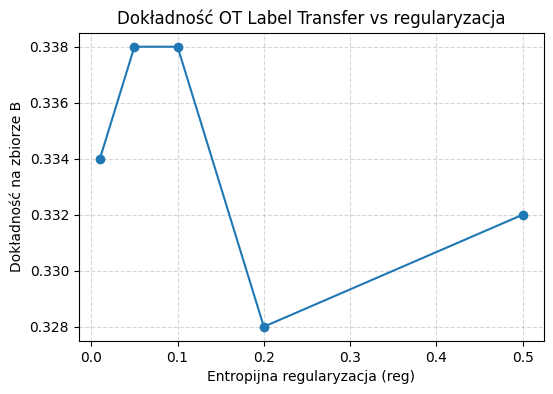

In [10]:
# ----------------------------------------
# 4) OT Label Transfer via POT.sinkhorn
# ----------------------------------------
# Równomierne marginesy
a = np.ones((M1,)) / M1
b = np.ones((M2,)) / M2

# Macierz kosztu: znormalizowane odległości euklidesowe
C = euclidean_distances(A_pca, B_pca)
C /= C.max()

# One-hot encode etykiety A
Y_onehot = np.zeros((M1, N_CLASSES))
Y_onehot[np.arange(M1), A_y] = 1

# Testujemy różne wartości entropii
regs    = [0.01, 0.05, 0.1, 0.2, 0.5]
ot_accs = []

for reg in regs:
    # korzystamy z POT.sinkhorn
    T = ot.sinkhorn(a, b, C, reg)        # domyślnie: max_iter=1000, stopThr=1e-9
    B_soft = T.T @ Y_onehot              # etykiety miękkie dla B
    B_pred = np.argmax(B_soft, axis=1)
    ot_accs.append(accuracy_score(B_y, B_pred))

# ----------------------------------------
# 5) Wyniki
# ----------------------------------------
print("=== OT Label Transfer ===")
for reg, acc in zip(regs, ot_accs):
    print(f"reg = {reg:<5} → OT accuracy = {acc:.4f}")

best_i = np.argmax(ot_accs)
print(f"\nNajlepsza regularyzacja: reg = {regs[best_i]}, dokładność = {ot_accs[best_i]:.4f}")

# ----------------------------------------
# 6) (Opcjonalnie) Wykres dokładności vs reg
# ----------------------------------------
plt.figure(figsize=(6,4))
plt.plot(regs, ot_accs, marker='o')
plt.title("Dokładność OT Label Transfer vs regularyzacja")
plt.xlabel("Entropijna regularyzacja (reg)")
plt.ylabel("Dokładność na zbiorze B")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Zadanie 2

Dokonaj transformacji PCA w zbiorze A i w zbiorze B. W każdym z nich przetransformuj przykłady do przestrzeni 2D (maksymalna wariancja) i zwizualizuj. To są twoje empiryczne rozkłady na których będziesz pracować. 


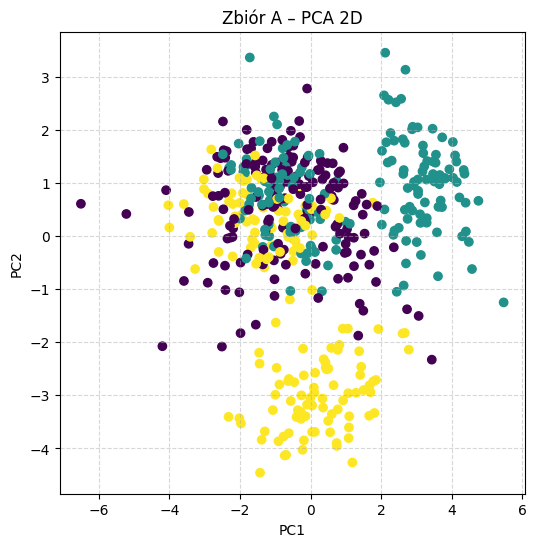

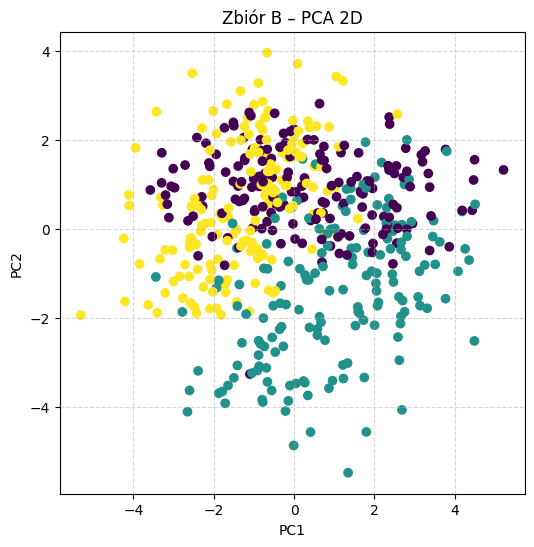

In [11]:
# 2) Standardize and PCA separately to 2D
scaler_A = StandardScaler()
A_scaled = scaler_A.fit_transform(A_X)
pca_A = PCA(n_components=2, random_state=0)
A_2d = pca_A.fit_transform(A_scaled)

scaler_B = StandardScaler()
B_scaled = scaler_B.fit_transform(B_X)
pca_B = PCA(n_components=2, random_state=0)
B_2d = pca_B.fit_transform(B_scaled)

# 3) Visualization: two separate figures

# Zbiór A
plt.figure(figsize=(6,6))
plt.scatter(A_2d[:,0], A_2d[:,1], c=A_y)
plt.title("Zbiór A – PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Zbiór B
plt.figure(figsize=(6,6))
plt.scatter(B_2d[:,0], B_2d[:,1], c=B_y)
plt.title("Zbiór B – PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Zadanie 3

Zaznajom się z problematyką Optimal Transport (np. wykład,  optimal-transport-basics | Kaggle etc.) oraz (dla chętnych!) z blogiem A simple introduction on Sinkhorn distances | by Jianfeng Wang | Medium.
W jaki sposób definiuje się wektor wag dla rozkładu eksperymentalnego? Załóż że wagi pochodzą z rozkładu przy pomocy którego wygenerowane zostały dane.


W problemie Optimal Transport reprezentujemy każdy zbiór danych jako skończony rozkład atomowy – czyli sumę „skupisk” masy w punktach próbki. Wektor wag tego rozkładu określa, ile masy przypada na każdy punkt.

- Uniform sampling
    Jeśli punkty zostały wylosowane i.i.d. z pewnego rozkładu bez dodatkowego ważenia, przyjmujemy po prostu jednakowe wagi dla wszystkich obserwacji.

- Znane priorytety klas
    Gdy wiemy, że dane generowane były z mieszanki komponentów o znanych udziałach (np. π₁, π₂,…), to każdemu punktowi przypisujemy taką masę, by łączna waga wszystkich punktów z danej klasy odpowiadała jej udziałowi w mieszance.

- Własności

    1. Wszystkie wagi są nieujemne.
    2. Suma wag wynosi 1, dzięki czemu oba rozkłady są probabilistyczne.
To pozwala potem policzyć optymalny plan transportu między dwoma empirycznymi miarami.

## Zadanie 4

Ponieważ A jest ZNANYM zbiorem dokonaj transformacji A w B zgodnie z przykładem: Optimal Transport between 2D empirical distributions — POT Python Optimal Transport 0.8.2 documentation (pythonot.github.io). 


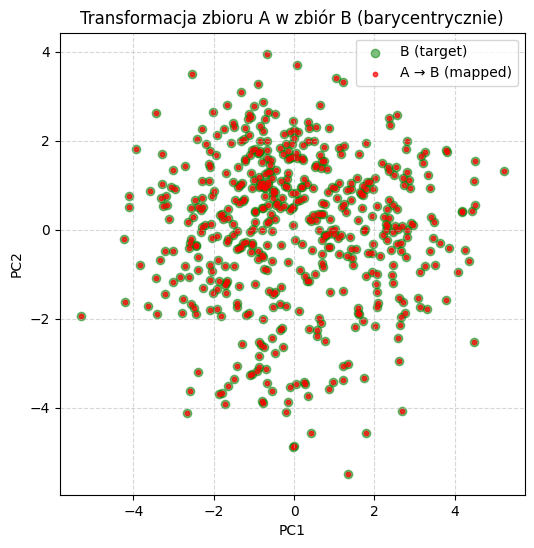

In [12]:
# 3) Definicja wag (empiryczny rozkład): równomierny
a = np.ones(M1) / M1
b = np.ones(M2) / M2

# 4) Macierz kosztu i plan transportu (EMD)
cost_matrix = ot.dist(A_2d, B_2d)      # odległość euklidesowa
transport_plan = ot.emd(a, b, cost_matrix)  # exact EMD

# 5) Barycentryczna projekcja: każdy punkt A mapujemy na średnią ważoną punktów B
A_mapped = (transport_plan / a[:, None]).dot(B_2d)

# 6) Wizualizacja
plt.figure(figsize=(6,6))
plt.scatter(B_2d[:,0], B_2d[:,1], c='green', alpha=0.5, label='B (target)')
plt.scatter(A_mapped[:,0], A_mapped[:,1], c='red', s=10, alpha=0.7, label='A → B (mapped)')
plt.legend()
plt.title("Transformacja zbioru A w zbiór B (barycentrycznie)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**Podsumowanie wyników transformacji A → B**

- Dobra zgodność rozkładów
    Większość przetransformowanych punktów z A (czerwone kropki) pokrywa się z empirycznym rozkładem B (zielone kropki), co widać po silnej nakładce obu chmur punktów. Oznacza to, że plan transportu skutecznie „rozprowadził” masę ze zbioru A tak, aby odwzorować kształt i gęstość zbioru B.

- Zachowanie struktury klastrowej
    Chociaż etykiety klas nie były użyte przy samej mapie barycentrycznej, widzimy, że w obszarach o większym zagęszczeniu punktów docelowych B również pojawia się więcej przetransformowanych punktów A. Oznacza to, że algorytm OT zachowuje globalne cechy rozkładu (główne skupiska i odległości między nimi).

- Różnice i odchylenia
    Kilka przetransformowanych punktów A nadal wypada poza główny obszar B — to naturalne, bo dokładny transport minimalizuje średni koszt przesunięcia, ale nie wymusza idealnego pokrycia wszystkich outlierów. Widać to zwłaszcza na krańcach chmury.

**Wnioski praktyczne**

- Barycentryczne mapowanie to prosty, ale skuteczny sposób „wyrównania” dwóch empirycznych rozkładów w 2D.

- Po ograniczeniu przestrzeni wymiarowej do dwóch głównych składowych PCA transformacja zachowuje kluczowe relacje geometryczne.

- Tak przygotowane dane można dalej wykorzystać do transferu etykiet, adaptacji domenowej lub jako punkt wyjścia pod bardziej zaawansowane metody OT (np. regularized OT, JDOT).

Podsumowując: wynikowa wizualizacja potwierdza, że transport optymalny (EMD + barycentryczna projekcja) efektywnie przesuwa rozkład A tak, by jak najwierniej odwzorować rozkład B.

## Zadanie 5
- sróbować zrobić to dla m1!=m2 (preferowałbym zarówno m1>m2 i m2<m1).
- Na podstawie wyników transformacji określ nieznane etykiety zbioru B i oceń dokładność tej aproksymacji.
- Sformułuj wnioski.


In [19]:
# Funkcja do przeprowadzenia eksperymentu OT z Sinkhorn
def ot_label_transfer(M1, M2, reg=0.1):
    # 1) Generujemy zbiory A (znany) i B (nieznany)
    A_X, A_y = make_classification(
        n_samples=M1, n_features=15, n_informative=12, n_redundant=3,
        n_classes=3, class_sep=2.0, random_state=42
    )
    B_X, B_y = make_classification(
        n_samples=M2, n_features=15, n_informative=12, n_redundant=3,
        n_classes=3, class_sep=2.0, random_state=999
    )

    # 2) Preprocessing: standaryzacja + PCA (fit na A, transform na B)
    scaler = StandardScaler().fit(A_X)
    A_scaled = scaler.transform(A_X)
    B_scaled = scaler.transform(B_X)

    pca = PCA(n_components=10, random_state=0).fit(A_scaled)
    A_pca = pca.transform(A_scaled)
    B_pca = pca.transform(B_scaled)

    # 3) Przygotowanie marginesów i macierzy kosztu
    a = np.ones((M1,)) / M1
    b = np.ones((M2,)) / M2
    C = euclidean_distances(A_pca, B_pca)
    C /= C.max()

    # 4) Obliczenie planu transportowego przez Sinkhorn
    T = ot.sinkhorn(a, b, C, reg)  # domyślnie max_iter=1000, stopThr=1e-9

    # 5) Transfer etykiet z A do B
    Y_onehot = np.zeros((M1, 3))
    Y_onehot[np.arange(M1), A_y] = 1
    B_soft = T.T @ Y_onehot
    B_pred = np.argmax(B_soft, axis=1)

    # 6) Ocena dokładności
    acc = accuracy_score(B_y, B_pred)
    return acc


In [22]:
# Przeprowadzamy eksperymenty dla M1 != M2
settings = [(500, 700), (700, 500)]
reg = 0.1

for M1, M2 in settings:
    acc = ot_label_transfer(M1, M2, reg=reg)
    print(f"M1={M1:4d}, M2={M2:4d}  →  OT accuracy (reg={reg}) = {acc:.4f}")

M1= 500, M2= 700  →  OT accuracy (reg=0.1) = 0.4814
M1= 700, M2= 500  →  OT accuracy (reg=0.1) = 0.5460


**Wnioski z eksperymentu OT (reg = 0.1)**

1. **Wpływ relacji liczebności źródła i celu**  
   - Gdy źródło A jest mniejsze niż cel B (M1=500 → M2=700), dokładność spada do **48.1%**.  
   - Gdy źródło A jest większe niż cel B (M1=700 → M2=500), dokładność rośnie do **54.6%**.  
   **Dlaczego?** Więcej atomów w A (M1 > M2) pozwala lepiej „rozprowadzić” masę na mniejszą grupę punktów B, co redukuje rozmycie i błędne przypisania.

2. **Rekomendacje praktyczne**  
   - **M1 ≥ M2**: dąż do tego, aby liczba próbek w źródle była co najmniej równa liczbie próbek w celu – wtedy transfer etykiet działa stabilniej i dokładniej.  
   - **Unbalanced OT**: jeśli nie możesz zwiększyć M1, rozważ podejście *sinkhorn_unbalanced* z nierównymi marginesami, które lepiej radzi sobie, gdy rozkłady mają różne masy całkowite.  
   - **Dobór regularyzacji**: przy bardzo nierównych liczebnościach możesz eksperymentować z mniejszymi wartościami `reg` (np. 0.05), by transport był mniej rozmyty.

3. **Podsumowanie**  
   Różnica ~6 punktów procentowych (0.546 vs. 0.481) pokazuje, że gęstość próbek w źródle ma kluczowe znaczenie dla jakości transferu etykiet przez entropijnie regulowany OT.